In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# from keras import Model, Input, layers, optimizers, losses, metrics
# from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
# from sklearn.model_selection import train_test_split
# import pandas as pd
# import numpy as np

# # Load the data
# df = pd.read_csv('./drive/MyDrive/VagusNerveResearchProject/vns_dataset_threshold_sim.csv')

# # Transform the data
# data_ab = df.copy()
# data_ab = data_ab[data_ab['C_activation_level'] == 0.0]
# data_ab = data_ab[['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'AB_activation_level']]
# data_ab.columns = ['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'activation_level']
# data_ab['fibre_type'] = 'AB'

# # Transform the data for C fibers
# data_c = df.copy()
# data_c = data_c[data_c['AB_activation_level'] == 1.0]
# data_c = data_c[['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'C_activation_level']]
# data_c.columns = ['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'activation_level']
# data_c['fibre_type'] = 'C'

# df_transformed = pd.concat([data_ab, data_c], ignore_index=True)

# df_transformed['charge'] = df_transformed['pulse_width'] * df_transformed['amplitude']

# df_transformed.to_csv('./drive/MyDrive/VagusNerveResearchProject/vns_dataset_threshold_type.csv', index=False)

In [3]:
from keras import Model, Input, layers, optimizers, losses, metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


data = pd.read_csv('./drive/MyDrive/VagusNerveResearchProject/vns_dataset_threshold_type.csv')

data.loc[data['fibre_type'] == 'AB', 'fibre_type'] = 0.0
data.loc[data['fibre_type'] == 'C', 'fibre_type'] = 1.0

# Encode the categorical feature
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

X_cat = one_hot_encode(data[['fibre_type']].astype('int'), num_classes=2)
X_cat = X_cat.reshape(-1, 2)

# Split the data
X = data.loc[:, ['nerve_a', 'nerve_b', 'activation_level', 'frequency']]
X.loc[:, 'fibre_type_AB'] = X_cat[:, 0]
X.loc[:, 'fibre_type_C'] = X_cat[:, 1]
y = data.loc[:, ['amplitude', 'pulse_width']]

# X.loc[X['fibre_type'] == 'AB', 'fibre_type'] = 0
# X.loc[X['fibre_type'] == 'C', 'fibre_type'] = 1
# X.loc[:, 'fibre_type'] = pd.to_numeric(X['fibre_type'])

In [10]:
X_ab = X[X['fibre_type_AB'] == 1.0]
X_c = X[X['fibre_type_C'] == 1.0]
y_ab = y[X['fibre_type_AB'] == 1.0]
y_c = y[X['fibre_type_C'] == 1.0]


# Normalize the continuous features
X_scaler_ab = StandardScaler()
X_ab_norm = X_scaler_ab.fit_transform(X_ab[['nerve_a', 'nerve_b', 'activation_level', 'frequency']])
X_scaler_c = StandardScaler()
X_c_norm = X_scaler_c.fit_transform(X_c[['nerve_a', 'nerve_b', 'activation_level', 'frequency']])

y_scaler_ab = StandardScaler()
y_ab_norm = y_scaler_ab.fit_transform(y_ab)
y_scaler_c = StandardScaler()
y_c_norm = y_scaler_c.fit_transform(y_c)

# X_ab_norm = np.hstack([X_ab_norm, X_ab[['fibre_type_AB', 'fibre_type_C']].values])
# X_c_norm = np.hstack([X_c_norm, X_c[['fibre_type_AB', 'fibre_type_C']].values])

X_norm = np.vstack([X_ab_norm, X_c_norm])
y_norm = np.vstack([y_ab_norm, y_c_norm])

X_train, X_test, y_train, y_test = train_test_split(X_ab_norm, y_ab_norm, test_size=0.2, random_state=42)

In [8]:
# 3D scatter plot of pulse width, amplitude and activation level
import plotly.graph_objs as go
import plotly.express as px


# Create the 3D scatter plot
fig = px.scatter_3d(
    x=y_c_norm[:, 0],
    y=y_c_norm[:, 1],
    z=X_c_norm[:, 2],
    color=X_c_norm[:, 0],
    opacity=0.6,
    size=np.ones_like(y_c_norm[:, 0])*0.5,
    color_continuous_scale='Viridis'
)

# Update the layout
fig.update_layout(
    scene=dict(
        xaxis_title='Amplitude',
        yaxis_title='Pulse Width',
        zaxis_title='Activation Level'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Show the plot
fig.show()

In [11]:
print(X_train[:5])
print(y_train[:5])

[[-2.04437172 -0.96007614 -1.45330895  0.31517841]
 [ 0.92610271  1.97471672 -1.12321727 -0.56748201]
 [ 1.23630436  0.13869448 -0.62840149 -0.80285812]
 [-2.04437172 -0.96007614  1.18645927 -0.80285812]
 [ 0.11077362  0.16791511 -0.21594776 -0.80285812]]
[[-0.22455999 -0.57363836]
 [-0.95258872  2.72348272]
 [ 0.28028705 -0.64690772]
 [ 0.42518108 -0.64690772]
 [-0.80417483  0.525402  ]]


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
def create_model() -> Model:
    # Define hyperparameters
    n_layers = 5
    activation = 'relu'

    # Input layer
    input_layer = Input(shape=(4,), name='input')
    x = input_layer

    use_batch_norm = True
    use_dropout = False
    dropout_rate = 0.2

    layer_sizes = [2048, 2048, 2048, 2048, 2048]

    # Hidden layers
    for i in range(n_layers):
        x = layers.Dense(layer_sizes[i], activation='relu' if activation == 'relu' else layers.LeakyReLU())(x)
        if use_batch_norm:
            x = layers.BatchNormalization()(x)
        if use_dropout:
            x = layers.Dropout(dropout_rate)(x)

    # Output layer
    output_layer = layers.Dense(2)(x)

    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model


model = create_model()

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    verbose=1,
)

# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)

Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 70s 473ms/step - loss: 3.3341 - mae: 1.3263 - val_loss: 1.0585 - val_mae: 0.7421
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 493ms/step - loss: 1.3570 - mae: 0.8810 - val_loss: 1.0548 - val_mae: 0.7296
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 80s 478ms/step - loss: 1.2600 - mae: 0.8552 - val_loss: 1.1069 - val_mae: 0.8082
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 78s 456ms/step - loss: 1.1554 - mae: 0.8199 - val_loss: 1.1285 - val_mae: 0.7643
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 461ms/step - loss: 1.1584 - mae: 0.8210 - val_loss: 1.1144 - val_mae: 0.7970
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 82s 462ms/step - loss: 1.0898 - mae: 0.7894 - val_loss: 1.1652 - val_mae: 0.8155
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 83s 474ms/step - loss: 1.0785 - mae: 0.7874 - val_loss: 1.1337 - val_mae: 0.7980
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 61s 470ms/step - loss: 1.0833 - mae: 0.7895 - val_loss: 1.0967 - val_mae: 0.7848
Epoch 9/100
131/131 ━━━━

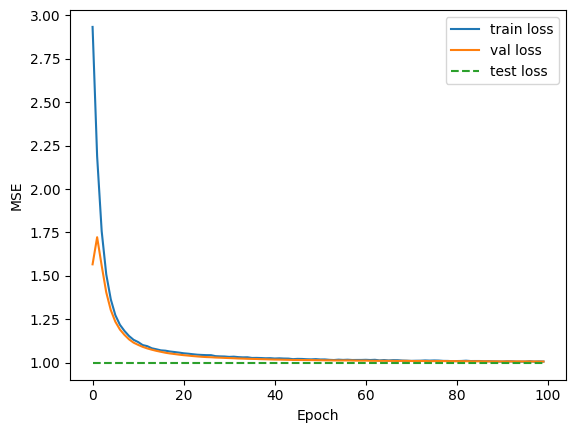

In [ ]:
# plot the training history
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.plot([score[0]]*len(history.history['loss']), label='test loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

In [ ]:
y_test.shape

(5692, 1)

In [ ]:
# Generate predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions
y_pred[X_test[:, 4] == 1.0, :] = y_scaler_ab.inverse_transform(y_pred[X_test[:, 4] == 1.0, :])
y_test[X_test[:, 4] == 1.0, :] = y_scaler_ab.inverse_transform(y_test[X_test[:, 4] == 1.0, :])
y_pred[X_test[:, 5] == 1.0, :] = y_scaler_c.inverse_transform(y_pred[X_test[:, 5] == 1.0, :])
y_test[X_test[:, 5] == 1.0, :] = y_scaler_c.inverse_transform(y_test[X_test[:, 5] == 1.0, :])


203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


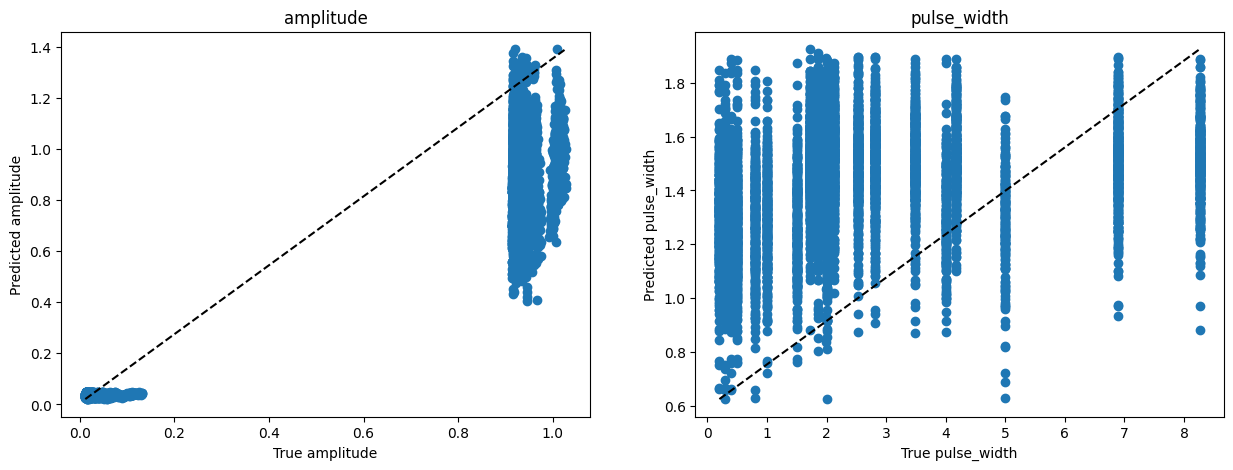

In [ ]:
# Plot the predictions for each output
params = ['amplitude', 'pulse_width']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.scatter(y_test[:, i], y_pred[:, i])
    ax.plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_pred[:, i]), max(y_pred[:, i])], linestyle='--', color='black')
    ax.set_xlabel(f'True {params[i]}')
    ax.set_ylabel(f'Predicted {params[i]}')
    ax.set_title(f'{params[i]}')


In [ ]:
best_model.save('parameter-model-20240724.keras')

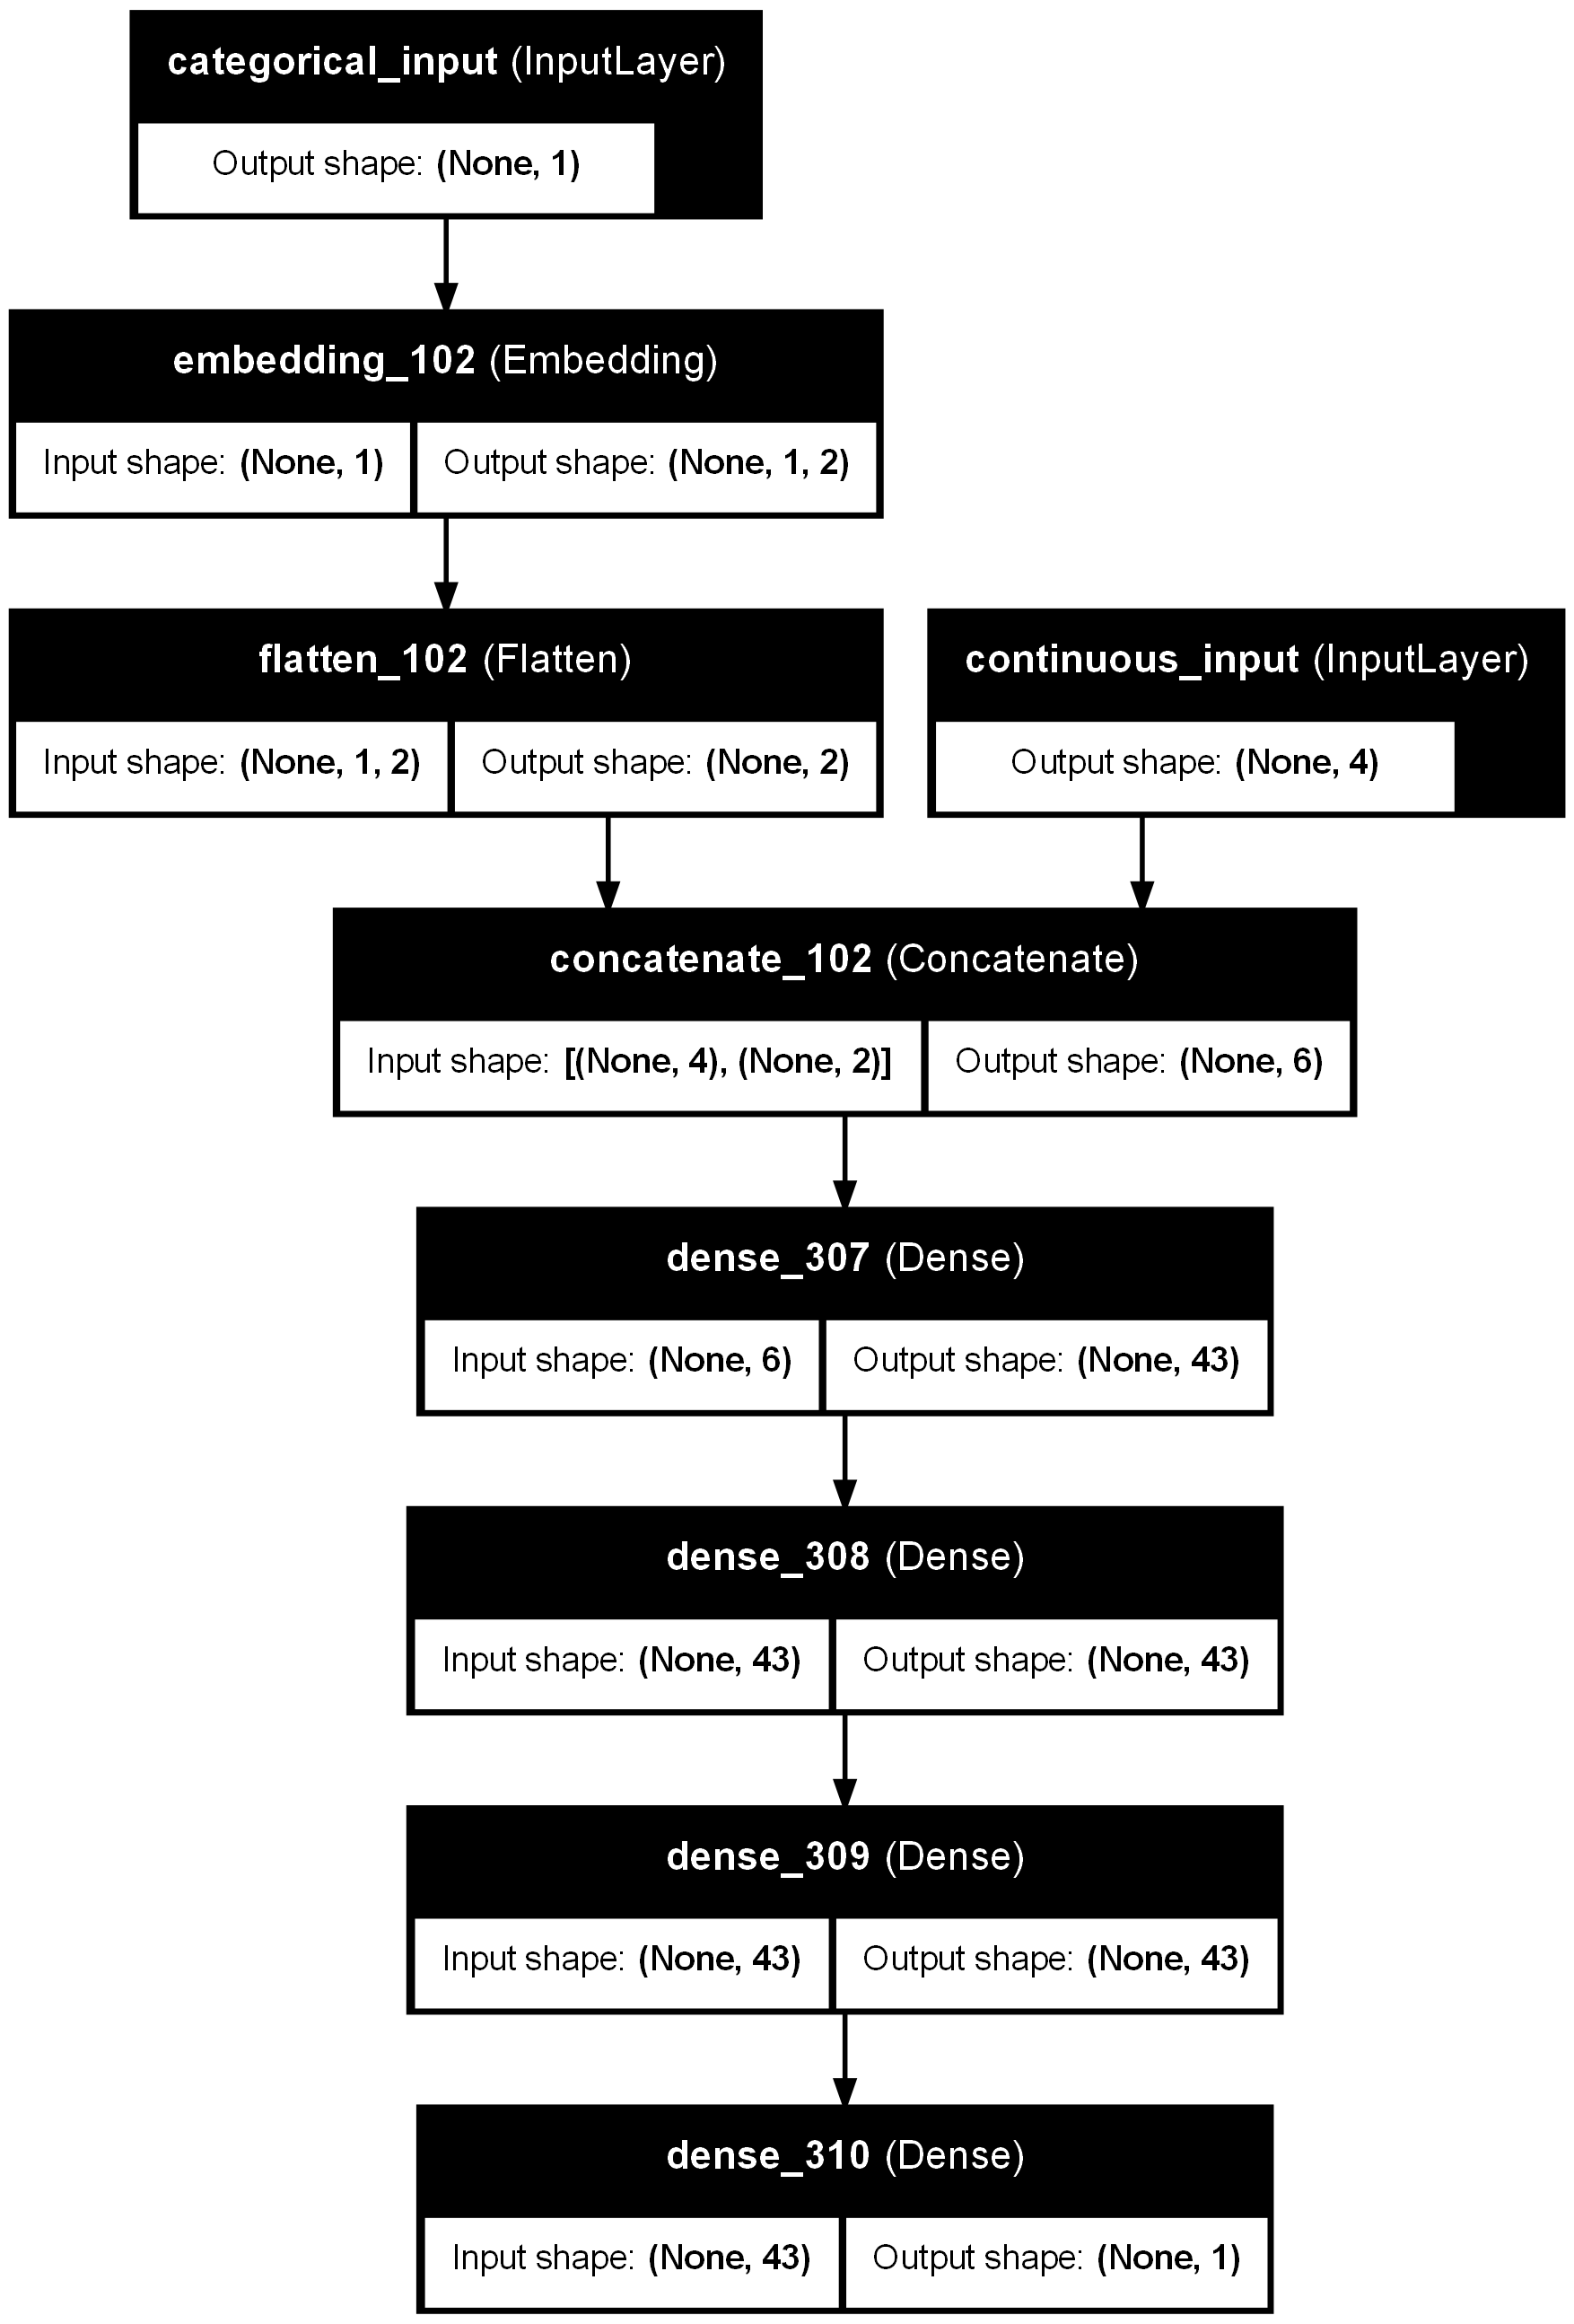

In [ ]:
from keras import utils

utils.plot_model(best_model, show_shapes=True, show_layer_names=True)

In [ ]:
# save study
import pickle

with open('./models/parameters-study.pkl', 'wb') as f:
    pickle.dump(study, f)

In [ ]:
from optuna.visualization import plot_contour

params = [
    'n_layers',
    'layer_size',
    'learning_rate'
]

plot_contour(study, target=lambda t: t.values[0], params=['n_layers', 'layer_size'])

In [ ]:
%pip install plotly

In [ ]:
# 3D scatter plot of pulse width, amplitude and activation level
import plotly.graph_objs as go
import plotly.express as px

X_test_denorm = X_test.copy()
X_test_denorm[:, :4] = scaler.inverse_transform(X_test_denorm[:, :4])

# Create the 3D scatter plot
fig = px.scatter_3d(
    x=y_pred[:, 0],
    y=y_pred[:, 1],
    z=X_test_denorm[:, 2],
    color=X_test_denorm[:, 3],
    opacity=0.6,
    color_continuous_scale='Viridis'
)

# Update the layout
fig.update_layout(
    scene=dict(
        xaxis_title='Amplitude',
        yaxis_title='Pulse Width',
        zaxis_title='Activation Level'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Show the plot
fig.show()